In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
N_BATCH = 64
N_EPOCH = 20
LR = 0.0001

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
!cp './drive/MyDrive/clab/dataset/intel_image_classification.tar' .

In [ ]:
!tar -xvf ./intel_image_classification.tar

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
seg_pred/seg_pred/4180.jpg
seg_pred/seg_pred/4183.jpg
seg_pred/seg_pred/4185.jpg
seg_pred/seg_pred/4188.jpg
seg_pred/seg_pred/4190.jpg
seg_pred/seg_pred/4195.jpg
seg_pred/seg_pred/4196.jpg
seg_pred/seg_pred/4198.jpg
seg_pred/seg_pred/420.jpg
seg_pred/seg_pred/4200.jpg
seg_pred/seg_pred/4201.jpg
seg_pred/seg_pred/4203.jpg
seg_pred/seg_pred/4204.jpg
seg_pred/seg_pred/4206.jpg
seg_pred/seg_pred/4207.jpg
seg_pred/seg_pred/4212.jpg
seg_pred/seg_pred/4213.jpg
seg_pred/seg_pred/4214.jpg
seg_pred/seg_pred/4216.jpg
seg_pred/seg_pred/4219.jpg
seg_pred/seg_pred/4220.jpg
seg_pred/seg_pred/4222.jpg
seg_pred/seg_pred/4223.jpg
seg_pred/seg_pred/4226.jpg
seg_pred/seg_pred/4229.jpg
seg_pred/seg_pred/423.jpg
seg_pred/seg_pred/4236.jpg
seg_pred/seg_pred/4237.jpg
seg_pred/seg_pred/424.jpg
seg_pred/seg_pred/4240.jpg
seg_pred/seg_pred/4241.jpg
seg_pred/seg_pred/4242.jpg
seg_pred/seg_pred/4243.jpg
seg_pred/seg_pred/4245.jpg
seg_pred/seg_pred/4246.jpg
seg_pred/seg_pred/4247

In [ ]:
data_dir = "."
train_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
val_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

In [ ]:
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
train_transform = T.Compose([
    T.Resize((299, 299)),
    T.ToTensor()
#     T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transform = T.Compose([
    T.Resize((299, 299)),
    T.ToTensor()
#     T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transform)
valset = torchvision.datasets.ImageFolder(root=val_dir, transform=val_transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=N_BATCH, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=N_BATCH, shuffle=False, num_workers=4)

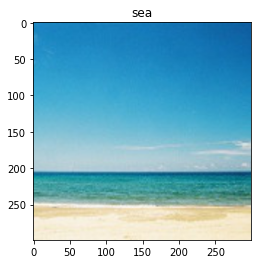

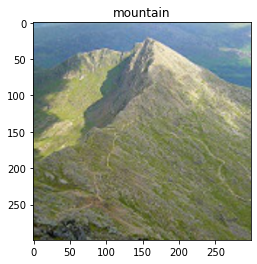

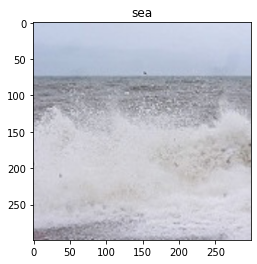

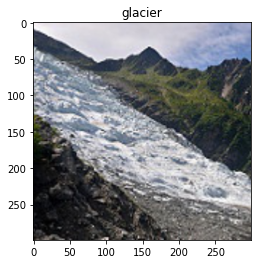

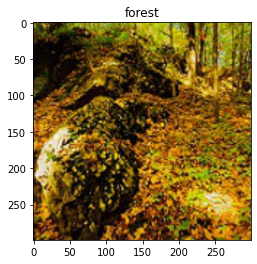

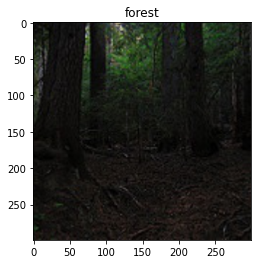

In [ ]:
i = 0
for images, labels in train_loader:
    image = images[0].numpy().transpose((1,2,0))
    plt.title(classes[labels[0].numpy()])
    plt.imshow(image)
    plt.show()
    if i > 4:
        break
    i += 1

In [ ]:
class ConvBN(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride=1, padding=0):
        super(ConvBN, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [ ]:
class Stem_1(nn.Module):
    def __init__(self):
        super(Stem_1, self).__init__()
        self.stem1 = nn.Sequential(
            ConvBN(3, 32, 3, 2),
            ConvBN(32, 32, 3),
            ConvBN(32, 64, 3, padding=1)
        )
    def forward(self, x):
        return self.stem1(x)

In [ ]:
class Stem_2(nn.Module):
    def __init__(self):
        super(Stem_2, self).__init__()
        self.maxpool = nn.MaxPool2d(3, 2)
        self.conv = ConvBN(64, 96, 3, 2)
    def forward(self, x):
        x0 = self.maxpool(x)
        x1 = self.conv(x)
        return torch.cat((x0, x1), dim=1)

In [ ]:
class Stem_3(nn.Module):
    def __init__(self):
        super(Stem_3, self).__init__()
        self.branch0 = nn.Sequential(
            ConvBN(160, 64, 1),
            ConvBN(64, 96, 3)
        )
        self.branch1 = nn.Sequential(
            ConvBN(160, 64, 1),
            ConvBN(64, 64, (7,1), 1, (3,0)),
            ConvBN(64, 64, (1,7), 1, (0,3)),
            ConvBN(64, 96, 3)
        )
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        return torch.cat((x0, x1), dim=1)

In [ ]:
class Stem_4(nn.Module):
    def __init__(self):
        super(Stem_4, self).__init__()
        self.conv = ConvBN(192, 192, 3, 2)
        self.maxpool = nn.MaxPool2d(3, 2)
    def forward(self, x):
        x0 = self.conv(x)
        x1 = self.maxpool(x)
        return torch.cat((x0, x1), dim=1)

In [ ]:
class Inception_A(nn.Module):
    def __init__(self):
        super(Inception_A, self).__init__()
        self.branch0 = nn.Sequential(
            nn.AvgPool2d(3, 1, padding=1, count_include_pad=False),
            ConvBN(384, 96, 1)
        )
        self.branch1 = ConvBN(384, 96, 1)
        self.branch2 = nn.Sequential(
            ConvBN(384, 64, 1),
            ConvBN(64, 96, 3, 1, 1)
        )
        self.branch3 = nn.Sequential(
            ConvBN(384, 64, 1),
            ConvBN(64, 96, 3, 1, 1),
            ConvBN(96, 96, 3, 1, 1)
        )
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        return torch.cat((x0, x1, x2, x3), dim=1)

In [ ]:
class Inception_B(nn.Module):
    def __init__(self):
        super(Inception_B, self).__init__()
        self.branch0 = nn.Sequential(
            nn.AvgPool2d(3, 1, padding=1, count_include_pad=False),
            ConvBN(1024, 128, 1)
        )
        self.branch1 = ConvBN(1024, 384, 1)
        self.branch2 = nn.Sequential(
            ConvBN(1024, 192, 1),
            ConvBN(192, 224, (1,7), 1, (0,3)),
            ConvBN(224, 256, (7,1), 1, (3,0))
        )
        self.branch3 = nn.Sequential(
            ConvBN(1024, 192, 1),
            ConvBN(192, 192, (1,7), 1, (0,3)),
            ConvBN(192, 224, (7,1), 1, (3,0)),
            ConvBN(224, 224, (1,7), 1, (0,3)),
            ConvBN(224, 256, (7,1), 1, (3,0))
        )
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        return torch.cat((x0, x1, x2, x3), dim=1)

In [ ]:
class Inception_C(nn.Module):
    def __init__(self):
        super(Inception_C, self).__init__()
        self.branch0 = nn.Sequential(
            nn.AvgPool2d(3, 1, padding=1, count_include_pad=False),
            ConvBN(1536, 256, 1)
        )
        self.branch1 = ConvBN(1536, 256, 1)
        self.branch2 = ConvBN(1536, 384, 1)
        self.branch2_0 = ConvBN(384, 256, (1,3), 1, (0,1))
        self.branch2_1 = ConvBN(384, 256, (3,1), 1, (1,0))
        self.branch3 = nn.Sequential(
            ConvBN(1536, 384, 1),
            ConvBN(384, 448, (1,3), 1, (0,1)),
            ConvBN(448, 512, (3,1), 1, (1,0))
        )
        self.branch3_0 = ConvBN(512, 256, (3,1), 1, (1,0))
        self.branch3_1 = ConvBN(512, 256, (1,3), 1, (0,1))
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x2_0 = self.branch2_0(x2)
        x2_1 = self.branch2_1(x2)
        x3 = self.branch3(x)
        x3_0 = self.branch3_0(x3)
        x3_1 = self.branch3_1(x3)
        return torch.cat((x0, x1, x2_0, x2_1, x3_0, x3_1), dim=1)

In [ ]:
class Reduction_A(nn.Module):
    def __init__(self):
        super(Reduction_A, self).__init__()
        self.branch0 = nn.MaxPool2d(3, 2)
        self.branch1 = ConvBN(384, 384, 3, 2)
        self.branch2 = nn.Sequential(
            ConvBN(384, 192, 1),
            ConvBN(192, 224, 3, 1, padding=1),
            ConvBN(224, 256, 3, 2)
        )
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        return torch.cat((x0, x1, x2), dim=1)

In [ ]:
class Reduction_B(nn.Module):
    def __init__(self):
        super(Reduction_B, self).__init__()
        self.branch0 = nn.MaxPool2d(3, 2)
        self.branch1 = nn.Sequential(
            ConvBN(1024, 192, 1),
            ConvBN(192, 192, 3, 2)            
        )
        self.branch2 = nn.Sequential(
            ConvBN(1024, 256, 1),
            ConvBN(256, 256, (1,7), 1, (0,3)),
            ConvBN(256, 320, (7,1), 1, (3,0)),            
            ConvBN(320, 320, 3, 2)
        )
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        return torch.cat((x0, x1, x2), dim=1)

In [ ]:
class InceptionV4(nn.Module):
    def __init__(self):
        super(InceptionV4, self).__init__()
        self.net = nn.Sequential(
            Stem_1(),
            Stem_2(),
            Stem_3(),
            Stem_4(),
            Inception_A(),
            Inception_A(),
            Inception_A(),
            Inception_A(),
            Reduction_A(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Reduction_B(),
            Inception_C(),
            Inception_C(),
            Inception_C()
        )
        self.fc = nn.Linear(1536, 1000)
    def forward(self, x):
        fmap = self.net(x)
        pool_ksize = fmap.shape[2]
        fmap = F.avg_pool2d(fmap, pool_ksize)
        fmap = fmap.view(fmap.size(0), -1)
        out = self.fc(fmap)
        return out

In [ ]:
model = InceptionV4()
model.to(device)

InceptionV4(
  (net): Sequential(
    (0): Stem_1(
      (stem1): Sequential(
        (0): ConvBN(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (1): ConvBN(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (2): ConvBN(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
      )
    )
    (1): Stem_2(
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): ConvBN(
        (conv): Conv2d(64, 96,

In [ ]:
import torchsummary
torchsummary.summary(model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
            ConvBN-4         [-1, 32, 149, 149]               0
            Conv2d-5         [-1, 32, 147, 147]           9,216
       BatchNorm2d-6         [-1, 32, 147, 147]              64
              ReLU-7         [-1, 32, 147, 147]               0
            ConvBN-8         [-1, 32, 147, 147]               0
            Conv2d-9         [-1, 64, 147, 147]          18,432
      BatchNorm2d-10         [-1, 64, 147, 147]             128
             ReLU-11         [-1, 64, 147, 147]               0
           ConvBN-12         [-1, 64, 147, 147]               0
           Stem_1-13         [-1, 64, 147, 147]               0
        MaxPool2d-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

In [ ]:
for epoch in range(N_EPOCH):
  print('Epoch {}/{}'.format(epoch+1, N_EPOCH))    
  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()
      dataloader = train_loader
    else:
      model.eval()
      dataloader = val_loader
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)      
        loss = criterion(outputs, labels)
        if phase == 'train':
          loss.backward()
          optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    if phase == 'train':
      epoch_loss = running_loss / len(trainset)
      epoch_acc = running_corrects.double() / len(trainset)
    else:
      epoch_loss = running_loss / len(valset)
      epoch_acc = running_corrects.double() / len(valset)
    
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc
    ))


print('Finishing Training')

Epoch 1/20
train Loss: 4.4799 Acc: 0.1944
val Loss: 2.1978 Acc: 0.2930
Epoch 2/20
train Loss: 1.6991 Acc: 0.4094
val Loss: 1.4861 Acc: 0.4403
Epoch 3/20
train Loss: 1.3873 Acc: 0.4811
val Loss: 1.3094 Acc: 0.5170
Epoch 4/20
train Loss: 1.2309 Acc: 0.5299
val Loss: 1.1528 Acc: 0.5623
Epoch 5/20
train Loss: 1.1420 Acc: 0.5547
val Loss: 1.0800 Acc: 0.5867
Epoch 6/20


KeyboardInterrupt: ignored

In [ ]:
test_dir = os.path.join(data_dir, 'seg_pred')
test_transform = T.Compose([
    T.Resize((299,299)),
    T.ToTensor()
])
testset = torchvision.datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=True, num_workers=4
)


In [ ]:
i = 0
for image, _ in test_loader:
    print_image = image[0].numpy().transpose((1,2,0))
    model.eval()
    image = image.to(device)
    out = model(image)    
    _, pred_class = torch.max(out, 1)
    plt.title(classes[pred_class])
    plt.imshow(print_image)
    plt.show()
    if i > 9:
        break
    i += 1